<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-deep-learning-timeseries-results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/philippmatthes/diplom

Cloning into 'diplom'...
remote: Enumerating objects: 2590, done.
remote: Counting objects: 100% (1927/1927), done.
remote: Compressing objects: 100% (1308/1308), done.
remote: Total 2590 (delta 1010), reused 1343 (delta 515), pack-reused 663
Receiving objects: 100% (2590/2590), 62.87 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (1386/1386), done.


In [1]:
# Switch to our src dir for further processing. This command is specific to 
# Google Colab, so it might not work on your local Jupyter Notebook instance

%cd /content/diplom/src

/content/diplom/src


In [2]:
# Mount Google Drive and Docs for data analysis

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Docs

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

docs = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
# Copy current savestate from gridsearch

datestr = '2021-08-29'

!mkdir /content/diplom/src/logs/
!unzip -n -d /content/diplom/src/logs/shl-gridsearch/ /content/drive/MyDrive/logs-{datestr}.zip
!unzip -n -d /content/diplom/src/models/shl-gridsearch/ /content/drive/MyDrive/gridsearch-{datestr}.zip

In [5]:
!ls /content/diplom/src/logs/shl-gridsearch/

0e010614e8698e02de6ea84ac08ea92a  7a39bbea52d7a11d80c7cf395e409540
17153f2a4bded620e375defd834ae96b  7cfd6602ff1ee897fd95deebf54ec24a
19b9fc45f42649dd56aa7eb9df5d6b2f  8aaa2b0d4bc28323ec5e5dda2b99b600
19d78461c5cb3c172b13f099311ea77b  92cf7c46d280478beb399b503d6773fd
2e36450ad2968ef7e675fa3e350736e1  968ca3e771b5efa5855ba841f69c463a
35d1710beb7573fa3d55a684e5e5d9a5  9988226d7297eb039365ad50f7c5ea0b
4ad2e771492aac5b42c89d9b5a835857  acc67cefc8f3e1f363b7be2278c5d6f8
4fafcd413fb89ba4ec2a052fdcc89ccb  bf1ba8ba4a66f98b650f95f4ff56665e
54579b011617e730136c7dc8c4f019b3  cb5048dd197b94c8b420dbcdb49f378f
60f59273ac339360b2b838511a3affd1  d120ad51d82d8966654d38c0bed18f6f
6af8a156f95b675b9ae9689d66c25b64  d5912676257ab43a4b8b0c94a0771fc2
6f7747c36067eecf4a1938dd5c1ee3c7  e6c36740f115fc7510ff472225bedeac
74f905b3244c57578f3e079db7d6910b  ea70373fe386b068ffab6704b4ac25fc
7523152748da6ca5d4d59234b3732c89  ed78d79eceb0d22006ed16af20d1cc5a


In [6]:
!ls /content/diplom/src/models/shl-gridsearch/

oracle.json				trial_7cfd6602ff1ee897fd95deebf54ec24a
trial_0e010614e8698e02de6ea84ac08ea92a	trial_8aaa2b0d4bc28323ec5e5dda2b99b600
trial_17153f2a4bded620e375defd834ae96b	trial_92cf7c46d280478beb399b503d6773fd
trial_19b9fc45f42649dd56aa7eb9df5d6b2f	trial_968ca3e771b5efa5855ba841f69c463a
trial_19d78461c5cb3c172b13f099311ea77b	trial_9988226d7297eb039365ad50f7c5ea0b
trial_2e36450ad2968ef7e675fa3e350736e1	trial_acc67cefc8f3e1f363b7be2278c5d6f8
trial_35d1710beb7573fa3d55a684e5e5d9a5	trial_af7a937bd3c52160ffadbfad1ba3adc1
trial_4ad2e771492aac5b42c89d9b5a835857	trial_bf1ba8ba4a66f98b650f95f4ff56665e
trial_4fafcd413fb89ba4ec2a052fdcc89ccb	trial_cb5048dd197b94c8b420dbcdb49f378f
trial_54579b011617e730136c7dc8c4f019b3	trial_d120ad51d82d8966654d38c0bed18f6f
trial_60f59273ac339360b2b838511a3affd1	trial_d5912676257ab43a4b8b0c94a0771fc2
trial_6af8a156f95b675b9ae9689d66c25b64	trial_e6c36740f115fc7510ff472225bedeac
trial_6f7747c36067eecf4a1938dd5c1ee3c7	trial_ea70373fe386b068ffab6704b4ac25fc
trial_74f9

In [3]:
import sys

!{sys.executable} -m pip install pandas==1.3.0 --upgrade -q

In [4]:
import os
import json
import tempfile
import shutil
import zipfile

from packaging import version
from pathlib import Path
from collections import defaultdict, OrderedDict

import tensorflow as tf
import pandas as pd
import tensorboard as tb
import numpy as np

from google.colab.files import download
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."

print("TensorBoard version: ", tb.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

TensorBoard version:  2.6.0
Pandas version:  1.3.0
Numpy version:  1.19.5


In [5]:
def parse_gridsearch_tf_logs(
    log_dir: Path, 
    metric_sources=['train', 'validation'],
    metrics=['epoch_loss', 'epoch_acc'],
) -> dict:
    data = defaultdict(dict)

    for trial_dir in [d for d in log_dir.iterdir() if d.is_dir()]:
        trial_id = trial_dir.parts[-1]
        
        for metric in metrics:
            for metric_source in metric_sources:
                ea = event_accumulator.EventAccumulator(
                    str(trial_dir / 'execution0' / metric_source),
                    size_guidance={event_accumulator.TENSORS: 0}
                )
                ea.Reload()

                if metric not in ea.Tags()['tensors']:
                    continue

                metric_tensors = ea.Tensors(metric)

                data[f'{metric_source}_{metric}'][trial_id] = {
                    'epochs': [t.step for t in metric_tensors],
                    'values': [tf.make_ndarray(t.tensor_proto) for t in metric_tensors],
                    'dates': [t.wall_time for t in metric_tensors],
                }
    
    return data

parsed_data = parse_gridsearch_tf_logs(Path('logs/shl-gridsearch'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

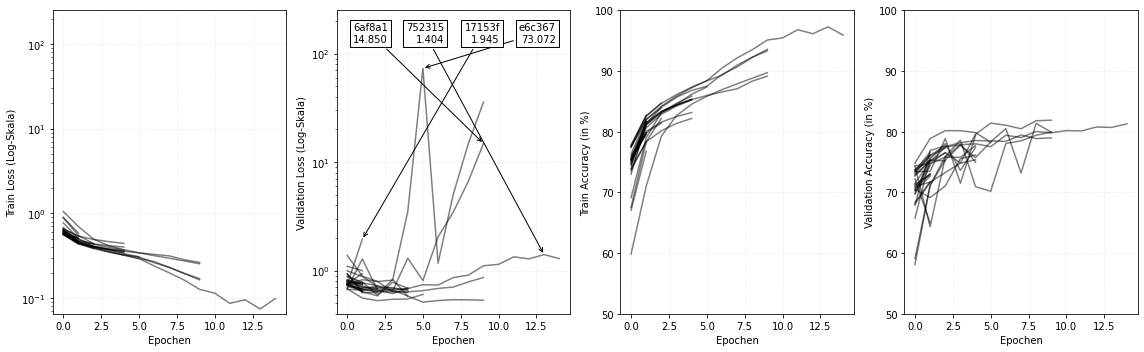

In [ ]:
plt.clf()

fig, axs = plt.subplots(1, len(parsed_data))
fig.set_size_inches(4 * len(parsed_data), 5)

metric_labels = {
    'train_epoch_loss': 'Train Loss (Log-Skala)',
    'validation_epoch_loss': 'Validation Loss (Log-Skala)',
    'train_epoch_acc': 'Train Accuracy (in %)',
    'validation_epoch_acc': 'Validation Accuracy (in %)',
}

metric_scales = {
    'train_epoch_loss': 'log',
    'validation_epoch_loss': 'log',
    'train_epoch_acc': 'linear',
    'validation_epoch_acc': 'linear',
}

for ax, (metric, trials_data) in zip(axs, parsed_data.items()):
    annotated_lines = 0
    for trial_id, data in trials_data.items():
        y = np.array(data['values'])
        ax.plot(y, color=(0, 0, 0, 0.5))

        if metric == 'validation_epoch_loss':
            x = np.array(list(range(len(y))))
            xmax = x[np.argmax(y)]
            ymax = np.array(y).max()

            if ymax > 1.4:
                text= f'{trial_id[:6]}\n{ymax:.3f}'
                if not ax:
                    ax=plt.gca()
                bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.")
                kw = dict(xycoords='data',textcoords="axes fraction",
                          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
                ax.annotate(text, xy=(xmax, ymax), xytext=(0.94 - annotated_lines * 0.24,0.96), **kw)
                annotated_lines += 1

        ax.set_yscale(metric_scales[metric])
        ax.grid(
            b = True, 
            color ='grey',
            linestyle ='-.', 
            linewidth = 0.5,
            alpha = 0.2
        )
    ax.set_ylabel(metric_labels[metric])
    ax.set_xlabel('Epochen')

axs[0].set_ylim(0, 250)
axs[1].set_ylim(0, 250)
axs[2].set_ylim(0.5, 1)
axs[2].set_yticklabels([int(t * 100) for t in axs[2].get_yticks()])
axs[3].set_ylim(0.5, 1)
axs[3].set_yticklabels([int(t * 100) for t in axs[3].get_yticks()])

plt.tight_layout()
plt.savefig(
    f'../images/shl/gridsearch-results.pdf',
    dpi=1200,
    bbox_inches='tight'
)

In [ ]:
download('../images/shl/gridsearch-results.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

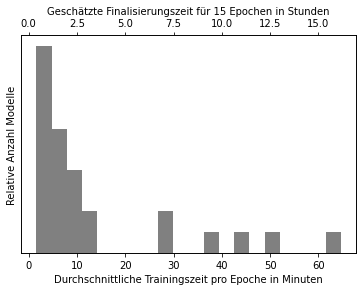

In [ ]:
plt.clf()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

diffs = []

for metric, trials_data in parsed_data.items():
    for trial_id, data in trials_data.items():
        dates = data['dates']
        diffs.append((dates[-1] - dates[0]) / len(dates) / 60)

ax1.set_yticks([])

ax1.hist(diffs, 20, color='grey')

ax1.set_xlabel('Durchschnittliche Trainingszeit pro Epoche in Minuten')
ax1.set_ylabel('Relative Anzahl Modelle')

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels([(t * 15) / 60 for t in ax1.get_xticks()])
ax2.set_xlabel('Geschätzte Finalisierungszeit für 15 Epochen in Stunden')

plt.savefig(
    f'../images/shl/gridsearch-finalization-prediction.pdf',
    dpi=1200,
    bbox_inches='tight'
)

In [ ]:
download('../images/shl/gridsearch-finalization-prediction.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
oracle_dir = Path('models/shl-gridsearch')

def load_trial_data():
    trial_data = defaultdict(dict)

    for trial_dir in [d for d in oracle_dir.iterdir() if d.is_dir()]:
        trial_json_dir = trial_dir / 'trial.json'
        with open(trial_json_dir) as f:
            trial_json = json.loads(f.read())
        trial_id = trial_json['trial_id']
        trial_hps = trial_json['hyperparameters']['values']
        for hp, hp_value in trial_hps.items():
            trial_data[hp][trial_id] = hp_value
        for metric, trials_data in parsed_data.items():
            if trial_id not in trials_data:
                continue
            trial_data[metric][trial_id] = trials_data[trial_id]['values']
    
    return trial_data

In [ ]:
df = pd.DataFrame(load_trial_data())

del df['tuner/initial_epoch']
del df['tuner/bracket']
del df['tuner/round']
del df['tuner/trial_id']
del df['train_epoch_loss']
del df['validation_epoch_loss']

df.dropna(inplace=True)

df['n_epochs'] = df['validation_epoch_acc'].apply(lambda x: len(x))
df['best_epoch'] = df['validation_epoch_acc'].apply(lambda x: np.where(x == np.amax(x))[0][0] + 1)
df['max_train_acc_pct'] = df['train_epoch_acc'].apply(lambda x: np.amax(x) * 100)
df['max_validation_acc_pct'] = df['validation_epoch_acc'].apply(lambda x: np.amax(x) * 100)

del df['tuner/epochs']
del df['validation_epoch_acc']
del df['train_epoch_acc']

df.sort_values(by=['max_validation_acc_pct', 'max_train_acc_pct'], inplace=True, ascending=False)

df.reset_index(inplace=True)

df['id'] = df['index'].apply(lambda x: x[:6])
del df['index']

df = df[[
    'id',
    'model_type',
    'version',
    'pooling',
    'optimizer',
    'n_stacks',
    'learning_rate',
    'n_epochs',
    'best_epoch',
    'max_train_acc_pct',
    'max_validation_acc_pct',
]]

df.rename(columns={
    'id': 'Trial-ID',
    'model_type': 'Typ',
    'version': 'Version',
    'n_stacks': 'Tiefe',
    'pooling': 'Pooling',
    'optimizer': 'Optimizer',
    'learning_rate': 'LR',
    'n_epochs': 'Epochen',
    'best_epoch': 'Beste',
    'max_train_acc_pct': 'Train Acc. (in \%)',
    'max_validation_acc_pct': 'Val. Acc. (in \%)',
}, inplace=True)

styled_df = df.style\
    .format({ 
        'LR': '{:.3f}',
        'Train Acc. (in \%)': '{:.2f}',
        'Val. Acc. (in \%)': '{:.2f}',
    }) \
    .hide_index() \
    .background_gradient(cmap='binary')
styled_df

Trial-ID,Typ,Version,Pooling,Optimizer,Tiefe,LR,Epochen,Beste,Train Acc. (in \%),Val. Acc. (in \%)
968ca3,1d,ResNetV1,max,sgd,2,0.100,10,10,89.16,81.91
6af8a1,1d,ResNetV1,max,adam,4,0.010,10,9,89.74,81.39
752315,2d,ResNetV2,avg,rmsprop,3,0.100,15,15,97.29,81.31
4ad2e7,1d,ResNetV1,max,adam,2,0.010,6,3,87.37,80.19
e6c367,1d,ResNetV1,avg,adam,3,0.001,10,10,93.59,79.94
35d171,2d,ResNetV1,avg,adam,2,0.010,10,8,93.33,79.46
7cfd66,1d,ResNetV1,max,sgd,2,0.100,5,5,85.23,79.42
ea7037,1d,ResNetV1,avg,adam,3,0.001,5,3,85.89,78.03
998822,1d,ResNetV2,max,sgd,2,0.010,5,4,85.36,77.95
cb5048,2d,ResNetV1,max,adam,2,0.010,5,5,85.32,77.74


In [ ]:
with open('../sections/evaluation/gridsearch-results.tex', 'w') as f:
    f.write(styled_df.to_latex(convert_css=True))

In [ ]:
download('../sections/evaluation/gridsearch-results.tex')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Finalization and profiling statistics

df = pd.DataFrame(load_trial_data())
df['max_train_acc_pct'] = df['train_epoch_acc'].apply(lambda x: np.amax(x) * 100)
df['max_validation_acc_pct'] = df['validation_epoch_acc'].apply(lambda x: np.amax(x) * 100)
df = pd.DataFrame(df.nlargest(10, ['max_validation_acc_pct']))

def get_model_size(trial_id):
    with tempfile.TemporaryDirectory() as dir:
        shutil.copyfile(f'/content/drive/MyDrive/finalization-tflite-model-{trial_id}.zip', f'{dir}/model.zip')
        with zipfile.ZipFile(f'{dir}/model.zip') as zip_ref:
            zip_ref.extractall(f'{dir}')
        n_bytes = os.path.getsize(f'{dir}/model.tflite')
    n_megabytes = n_bytes / 1_000_000
    return n_megabytes

def get_model_finalization_log(trial_id):
    with tempfile.TemporaryDirectory() as dir:
        shutil.copyfile(f'/content/drive/MyDrive/finalization-log-{trial_id}.zip', f'{dir}/log.zip')
        with zipfile.ZipFile(f'{dir}/log.zip') as zip_ref:
            zip_ref.extractall(f'{dir}')
        log_df = pd.read_csv(f'{dir}/log.csv')
    return log_df

model_sizes = []
model_logs = []
for trial_id in df.index:
    model_sizes.append(get_model_size(trial_id))
    model_logs.append(get_model_finalization_log(trial_id))

df['model_size_mb'] = model_sizes
df['finalization_log'] = model_logs

df['finalization_epochs'] = df['finalization_log'].apply(lambda log_df: max(log_df['epoch']) + 1)
df['finalization_train_acc_pct'] = df['finalization_log'].apply(lambda log_df: max(log_df['acc']) * 100)
df['finalization_val_acc_pct'] = df['finalization_log'].apply(lambda log_df: max(log_df['val_acc']) * 100)

df['trial_rank'] = [i + 1 for i in range(len(df.index))]

df['finalization_diff_acc_pct'] = df.apply(lambda row: row['finalization_train_acc_pct'] - row['finalization_val_acc_pct'], axis=1)

finalization_df = df.copy()
finalization_df = finalization_df[[
    'model_type',
    'trial_rank',
    'max_validation_acc_pct',
    'max_train_acc_pct',
    'finalization_train_acc_pct',
    'finalization_val_acc_pct',
    'finalization_diff_acc_pct',
    'model_size_mb'
]]

finalization_df.sort_values(by=['finalization_val_acc_pct', 'finalization_train_acc_pct'], inplace=True, ascending=False)

finalization_df.reset_index(inplace=True)

finalization_df['index'] = finalization_df['index'].apply(lambda x: x[:6])

finalization_df.rename(columns={
    'index': 'Trial-ID',
    'trial_rank': 'Trial-Rang',
    'model_type': 'Typ',
    'version': 'Version',
    'pooling': 'Pooling',
    'optimizer': 'Optimizer',
    'max_train_acc_pct': 'Trial Train Acc. (in \%)',
    'max_validation_acc_pct': 'Trial Val. Acc. (in \%)',
    'finalization_train_acc_pct': 'Fin. Train Acc. (in \%)',
    'finalization_val_acc_pct': 'Fin. Val. Acc. (in \%)',
    'finalization_diff_acc_pct': 'Fin. Acc. Diff (in \%)',
    'model_size_mb': 'Größe (in MB)',
}, inplace=True)

finalization_df_styled = finalization_df.style \
    .format({ 
        'Trial Train Acc. (in \%)': '{:.2f}',
        'Trial Val. Acc. (in \%)': '{:.2f}',
        'Fin. Train Acc. (in \%)': '{:.2f}',
        'Fin. Val. Acc. (in \%)': '{:.2f}',
        'Fin. Acc. Diff (in \%)': '{:.2f}',
        'Größe (in MB)': '{:.2f}',
    }) \
    .hide_index() \
    .background_gradient(cmap='binary')

finalization_df_styled

Trial-ID,Typ,Trial-Rang,Trial Val. Acc. (in \%),Trial Train Acc. (in \%),Fin. Train Acc. (in \%),Fin. Val. Acc. (in \%),Fin. Acc. Diff (in \%),Größe (in MB)
4ad2e7,1d,4,80.19,87.37,90.77,84.34,6.43,3.96
6af8a1,1d,2,81.39,89.74,95.74,84.18,11.56,154.50
7cfd66,1d,7,79.42,85.23,91.14,84.18,6.96,6.91
968ca3,1d,1,81.91,89.16,91.26,84.03,7.23,6.91
e6c367,1d,5,79.94,93.59,93.01,83.69,9.32,110.53
998822,1d,9,77.95,85.36,92.47,82.92,9.55,6.91
752315,2d,3,81.31,97.29,96.78,81.33,15.45,168.53
35d171,2d,6,79.46,93.33,96.63,81.07,15.57,10.36
ea7037,1d,8,78.03,85.89,91.79,81.01,10.77,110.53
cb5048,2d,10,77.74,85.32,89.72,78.96,10.75,5.88


In [ ]:
with open('../sections/evaluation/finalization-results.tex', 'w') as f:
    f.write(finalization_df_styled.to_latex(convert_css=True))

In [ ]:
download('../sections/evaluation/finalization-results.tex')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

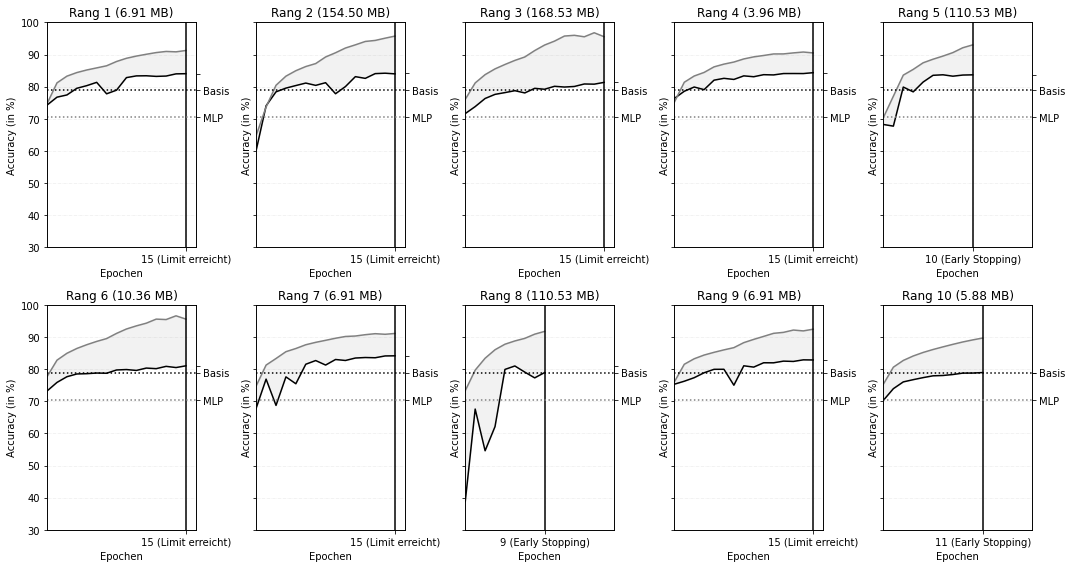

In [ ]:
plt.clf()
fig, axs = plt.subplots(2, 5, sharey=True)
fig.set_size_inches(3 * 5, 4 * 2)

for ax, trial_id in zip(axs.flatten(), df.index):
    val_acc = df['finalization_log'][trial_id]['val_acc']
    train_acc = df['finalization_log'][trial_id]['acc']
    ax.plot([acc * 100 for acc in val_acc], color='black')
    ax.plot([acc * 100 for acc in train_acc], color='grey')
    ax.fill_between(
        x=[i for i in range(len(val_acc))],
        y1=[acc * 100 for acc in val_acc],
        y2=[acc * 100 for acc in train_acc],
        color=(0, 0, 0, 0.05)
    )
    ax.set_title(f'Rang {list(df.index).index(trial_id) + 1} ({df["model_size_mb"][trial_id]:0.2f} MB)')
    ax.set_xlabel('Epochen')

    ax.grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )

    ax.set_ylabel('Accuracy (in %)')
    ax.set_ylim(30, 100)
    ax.set_xlim(0, 15)
    ax.axvline(len(val_acc) - 1, color='black')

    ax.axhline(78.94, color='black', linestyle=':')
    ax.axhline(70.42, color='grey', linestyle=':')

    ax.set_xticks([len(val_acc) - 1])
    es = len(val_acc) != 15

    ax.set_xticklabels([f'{len(val_acc)}{" (Early Stopping)" if es else " (Limit erreicht)"}'])

    rax = ax.twinx()
    rax.set_ylim(ax.get_ylim())
    rax.set_yticks([max([acc * 100 for acc in val_acc]), 78.94, 70.42])
    rax.set_yticklabels(['', 'Basis', 'MLP'])

plt.tight_layout()
plt.savefig(
    f'../images/shl/finalization-results-accuracy.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

In [ ]:
download('../images/shl/finalization-results-accuracy.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

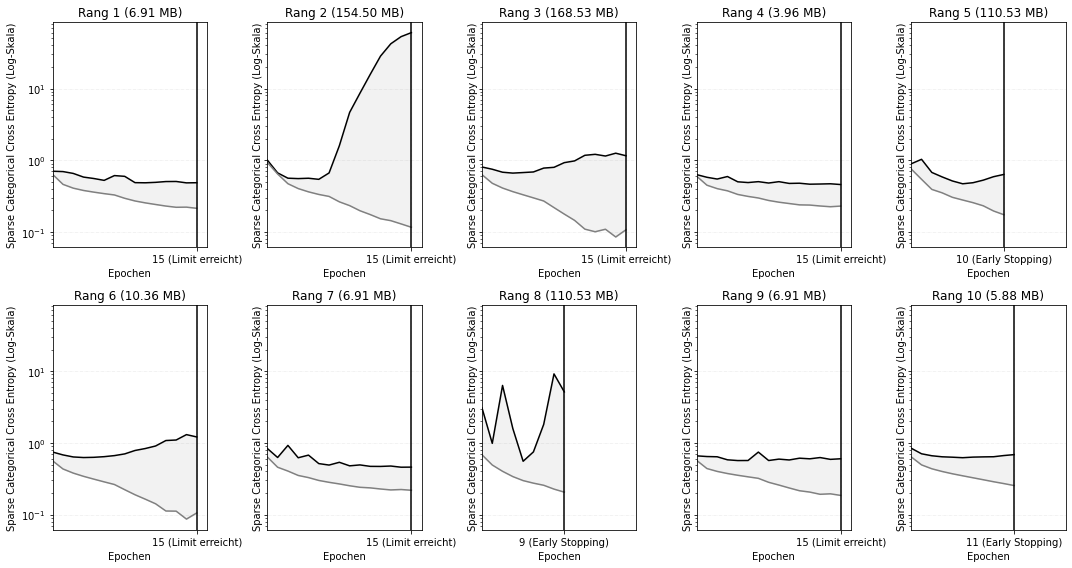

In [ ]:
plt.clf()
fig, axs = plt.subplots(2, 5, sharey=True)
fig.set_size_inches(3 * 5, 4 * 2)

for ax, trial_id in zip(axs.flatten(), df.index):
    val_loss = df['finalization_log'][trial_id]['val_loss']
    train_loss = df['finalization_log'][trial_id]['loss']
    ax.plot(val_loss, color='black')
    ax.plot(train_loss, color='grey')
    ax.fill_between(
        x=[i for i in range(len(val_loss))],
        y1=val_loss,
        y2=train_loss,
        color=(0, 0, 0, 0.05)
    )
    ax.set_title(f'Rang {list(df.index).index(trial_id) + 1} ({df["model_size_mb"][trial_id]:0.2f} MB)')
    ax.set_xlabel('Epochen')

    ax.grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )

    ax.set_ylabel('Sparse Categorical Cross Entropy (Log-Skala)')
    ax.set_yscale('log')
    ax.set_xlim(0, 15)
    ax.axvline(len(val_loss) - 1, color='black')

    ax.set_xticks([len(val_loss) - 1])
    es = len(val_loss) != 15

    ax.set_xticklabels([f'{len(val_loss)}{" (Early Stopping)" if es else " (Limit erreicht)"}'])

plt.tight_layout()
plt.savefig(
    f'../images/shl/finalization-results-loss.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

In [ ]:
download('../images/shl/finalization-results-loss.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Tradeoff

sheet = docs.open('Profiling').sheet1
tradeoff_params = sheet.get_all_values()

tradeoff_param_names = [params[0] for params in tradeoff_params]
tradeoff_param_values = [params[1:] for params in tradeoff_params]

tradeoff_dict = OrderedDict(zip(tradeoff_param_names, tradeoff_param_values))
tradeoff_df = pd.DataFrame.from_records(tradeoff_dict)
tradeoff_df['Trial-ID'] = tradeoff_df['Trial-ID'].apply(lambda id: id[:6])
tradeoff_df.set_index('Trial-ID', inplace=True)

for column in tradeoff_df.columns:
    tradeoff_df[column] = pd.to_numeric(tradeoff_df[column], errors='coerce')

tradeoff_df['Operationen'] = tradeoff_df['Operationen'].astype(int)
tradeoff_df['Operationen auf GPU'] = tradeoff_df['Operationen auf GPU'].astype(int)
tradeoff_df['Operationen auf ANE'] = tradeoff_df['Operationen auf ANE'].astype(int)

tradeoff_df = tradeoff_df
tradeoff_df = tradeoff_df[[
    n for n in tradeoff_param_names if n != 'Trial-ID'
]]

tradeoff_df_to_print = tradeoff_df.T.style.format('{:.2f}', na_rep='k.A.').background_gradient(cmap='binary', axis=1)
tradeoff_df_to_print

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2742: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2743: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


Trial-ID,6af8a1,968ca3,752315,4ad2e7,e6c367,35d171,7cfd66,ea7037,998822,cb5048
Max. Validation-Accuracy (in \%),84.18,84.03,81.33,84.34,83.69,81.07,84.18,81.01,82.92,78.96
Modellgröße (in MB),154.50,6.91,168.53,3.96,110.53,10.36,6.91,110.53,6.91,5.88
Operationen,515.00,122.00,362.00,83.00,444.00,101.00,123.00,444.00,162.00,85.00
Operationen auf GPU,6.00,6.00,317.00,6.00,6.00,56.00,6.00,6.00,6.00,40.00
Operationen auf ANE,110.00,23.00,319.00,20.00,94.00,58.00,28.00,94.00,50.00,42.00
RAM-Usage iPhone SE CPU (in MB),27.14,19.36,22.20,19.31,21.03,20.47,19.36,21.06,19.38,20.49
RAM-Usage iPhone SE GPU (in MB),36.36,21.14,347.08,26.34,29.75,45.86,27.00,30.47,27.16,38.06
RAM-Usage iPhone XS CPU (in MB),28.38,20.59,23.50,20.59,22.35,21.74,20.61,22.33,20.63,21.70
RAM-Usage iPhone XS GPU (in MB),37.85,22.59,347.60,26.84,30.28,46.27,27.47,30.86,27.58,38.49
RAM-Usage iPhone XS ANE (in MB),61.81,31.53,32.58,29.31,53.66,28.08,32.42,54.47,43.69,28.91


In [ ]:
with open('../sections/evaluation/tradeoff-results.tex', 'w') as f:
    f.write(tradeoff_df_to_print.to_latex(convert_css=True))

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2742: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2743: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [ ]:
download('../sections/evaluation/tradeoff-results.tex')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>